<h1>Problem Statement</h1>
<h3>You are provided with a text corpora of a Digital media news channel in two different languages, namely english and hindi. You are given the task of finding out the most related stories for every article in the text corpus.</h3>

The data is in the form of csv with 5 columns:
<ul>
<li>ArticleId - Id of the story as given by the news channel. </li>
<li>Language - Language in which the story was published.</li>
<li>Content - Text of the article.</li>
<li>Title - Title of the story published. </li>
<li>Type - This is the type of the story published like gallery, video, etc. </li>
</ul>

<h1>Output</h1>
<h3>
You are expected to find out 6 related articles against every article in the corpus in the form of CSV - with first column being the title of first story and next 6 being the title of related articles.
Also along with the result submission the implementation in the form of a python notebook is also expected to be submitted.
</h3>

<h4>Workflow</h4>

<h4>Model Building:</h4> 

We will make model with <b>Tfidf(Term frequency - inverse term frequency) and cosine similarity</b>. Features will be made from the <b>Content attribute</b>.

Since, we are making features from the Content attribute, we will need to remove articles which may have null value in the Content field in the Dataset.

In [44]:
# necessary librares
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup
import string 
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import linear_kernel

In [45]:
articles = pd.read_csv("articles.csv", header = None, names = ['ArticleId','Language','Title','Content','Type'])
print(articles.shape)

(5649, 5)


<h2>Exploratory data analysis</h2>

In [46]:
articles.head()

,ArticleId,Language,Title,Content,Type
0,676946,english,"Fadnavis, Piyush Goyal perform 'bhoomi pujan' ...",NaN,standard
1,676943,english,Trump freezes $200 mn in Syrian recovery funds...,NaN,standard
2,676946,english,"Fadnavis, Piyush Goyal perform 'bhoomi pujan' ...","<p>Latur (Maharashtra) [India], Apr. 1 (ANI): ...",standard
3,676941,english,Bhagalpur violence: Arijit Shashwat surrenders,"<p>Patna (Bihar) [India], Apr. 1 (ANI): Union ...",standard
4,676941,english,Bhagalpur violence: Arijit Shashwat surrenders,NaN,standard


In [47]:
## Statistical overview ##
articles.describe()

,ArticleId,Language,Title,Content,Type
count,5649,5649,5649,4133,5649
unique,1751,2,2012,2326,3
top,681478,english,Unnao gangrape: Victim's father did not die in...,"<p style=\""text-align: justify;\""><strong>लखनऊ...",standard
freq,45,3001,20,14,3503


<h3>Total rows in dataframe : 5649 </h3>
<h3><u>Missing values</u> only in 'Content' feature</h3>
<ul>
<li>Unique ArticleId : 1751 </li>
<li>Unique Languages : 2 (Hindi & English) </li>
<li>Unique Title : 2012 </li>
<li>Unique Content : 2326 </li>
<li>Unique Type : 3 (Standard, video, gallery) </li>
</ul>

In [48]:
##### checking missing data in a data frame data ####
total = articles.isnull().sum().sort_values(ascending = False)
percent = (articles.isnull().sum()/articles.isnull().count()*100).sort_values(ascending = False)
missing_articles  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_articles.head()

,Total,Percent
Content,1516,26.836608
Type,0,0.000000
Title,0,0.000000
Language,0,0.000000
ArticleId,0,0.000000


<h4>We have missing values only in the Content feature in our dataset</h4>

<h3>We can add Content inplace of NaN from different row with same ArticleId OR We can delete the row with NaN vaue. Replacing NaN with same content will not have any meaning since we will want to work with unique contents for our information retieval system.</h3>

english    3001
hindi      2648
Name: Language, dtype: int64


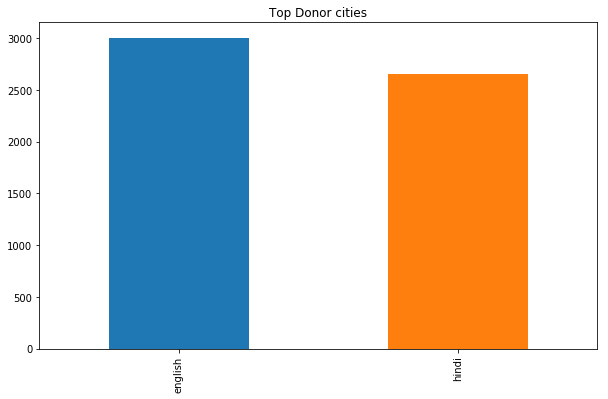

In [49]:
temp = articles["Language"].value_counts()
print(temp)

#print(type(temp))
temp.plot(kind='bar', title = 'Top Donor cities', figsize=(10,6))
plt.show()

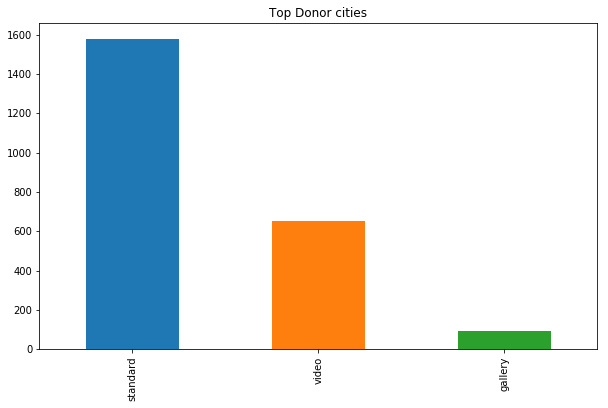

In [90]:
temp = articles["Type"].value_counts()
#print(temp)

#print(type(temp))
temp.plot(kind='bar', title = 'Top Donor cities', figsize=(10,6))
plt.show()

<h3>
<ol>
<li>Standard: 1580</li>
<li>Video: 653 </li>
<li>Gallery: 93</li>
</ol>
</h3>

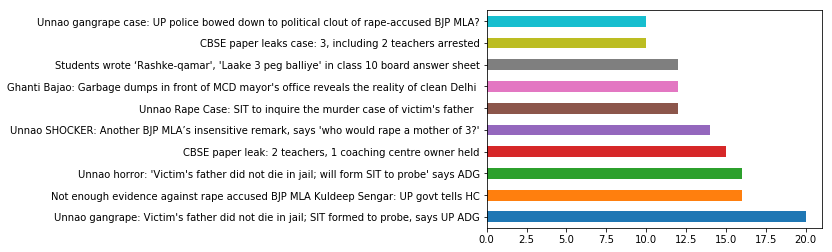

In [51]:
## Most repeted articles in the dataframe ###
articlesEnglish = articles.loc[articles['Language'] == 'english', :]
articlesEnglish['Title'].value_counts()[:10].plot(kind = 'barh')
plt.show()

<h3>Highest frequency of an English article is occuring is 8 times</h3>

<h1>Data Pre-Processing</h1>

<h4>
We have a lot of duplicate entries in our dataset, which can be seen from the same articleId inn the dataset. 
Let us examine these DUPLICATE ENTRIES.
</h4>

In [52]:
## dataframe showing similar article ID  rows ##
pd.concat(g for _, g in articles.groupby("ArticleId") if len(g) > 1)

,ArticleId,Language,Title,Content,Type
7,676938,english,Kodandaram's party gets green signal,"<p>Hyderabad, (Telangana) [India] April. 1 (AN...",standard
10,676938,english,Kodandaram's party gets green signal,NaN,standard
18,676938,english,Kodandaram's party gets green signal,NaN,standard
20,676938,english,Kodandaram's party gets green signal,"<p>Hyderabad, (Telangana) [India] April. 1 (AN...",standard
21,676938,english,Kodandaram's party gets green signal,NaN,standard
24,676938,english,Kodandaram's party gets green signal,NaN,standard
29,676938,english,Kodandaram's party gets green signal,"<p>Hyderabad, (Telangana) [India] April. 1 (AN...",standard
36,676938,english,Kodandaram's party gets green signal,"<p>Hyderabad, (Telangana) [India] April. 1 (AN...",standard
14,676939,english,Imam who lost son in Asansol riot appeals for ...,"<p>Asansol (West Bengal) [India], April .1 (AN...",standard
15,676939,english,Imam who lost son in Asansol riot appeals for ...,NaN,standard


In [53]:
 newframe = pd.concat(g for _, g in articles.groupby("ArticleId") if len(g) > 1)

<h4>Deleting rows with Duplicate entries in "ArticleID" and NaN entry in the "Content" field </h2>

In [54]:
## getting index of the rows to be deleted ##
ToDeleteIndex = newframe[newframe['Content'].isnull()].index
## dropping indentified rows ##
articles.drop(articles.index[list(ToDeleteIndex)], inplace=True)

In [55]:
#####  Missing values after deleting rows with duplicate 'ArticleId' and 'NaN' in Content field  #####33
totalAf = articles.isnull().sum().sort_values(ascending = False)
percentAf = (articles.isnull().sum()/articles.isnull().count()*100).sort_values(ascending = False)
missing_articlesAf  = pd.concat([totalAf, percentAf], axis=1, keys=['Total', 'Percent'])
missing_articlesAf.head()

,Total,Percent
Content,4,0.096688
Type,0,0.000000
Title,0,0.000000
Language,0,0.000000
ArticleId,0,0.000000


In [56]:
articles.shape

(4137, 5)

rows deleted <br>
1512

<h3>Now, we will delete rows which have<u> duplicate Title and Content Combination </u>as well. <br>
Note: We may still have rows with Nan entry in the content field.</h3>
<br>
<h3>We are dropping rows with same 'Title' and 'Content' combination. </h3>

In [57]:
articles.drop_duplicates(subset=['Title','Content'], keep='first', inplace=True)

In [58]:
#####  Dataframe shape after deleting complete duplicate rows #########
articles.shape

(2600, 5)

<h3>Dropping rows with same "Content" as well</h3>

In [59]:
####  Dropping rows with same "Content" as well  ######
articles.drop_duplicates(subset="Content", keep='first', inplace = True)
print(articles.shape)

(2327, 5)


<h2>Now, we only have <u>unique</u> Contents in "Content" feature.</h2>
<br>
<h1>We are working on unique "Content" because obtaining same Article by information retieval will not have any meaning.</h1>
<br>
<h3>We will make use of Content feature for relevent Information retrival from the document</h3>

<h1>Another way to Clean the data(Simpler)</h1>
<ol>

<h2><li>Delete the rows with NaN entris in the 'Content' field</li></h2>
<h2><li>Delete the rows with same entries in the 'Title' and 'Content' field</li></h2>
</ol>

In [60]:
#len(articles['Content'].unique())

In [61]:
## dataframe showing similar article ID  rows
pd.concat(g for _, g in articles.groupby("ArticleId") if len(g) > 1)

,ArticleId,Language,Title,Content,Type
323,676957,english,J&K: Encounter between security forces & terro...,"New Delhi: On Sunday morning, encounter broke ...",standard
324,676957,english,J&K: Two militants killed in separate encounte...,<strong>Srinagar:</strong> Two militants were ...,standard
344,676957,english,J&K: Encounter between security forces & terro...,"New Delhi: On Sunday morning, two encounters b...",standard
356,676957,english,J&K: Encounter between security forces & terro...,"New Delhi: On Sunday morning, two encounters b...",standard
390,676999,english,"CBSE paper leaks case: 3, including 2 teachers...",New Delhi: In the latest development in CBSE p...,standard
399,676999,english,"CBSE paper leaks case: 3, including 2 teachers...",New Delhi: In the latest development in CBSE p...,standard
402,676999,english,"CBSE paper leaks case: 3, including 2 teachers...",New Delhi: In the latest development in CBSE p...,standard
403,676999,english,"CBSE paper leaks case: 3, including 2 teachers...",New Delhi: In the latest development in CBSE p...,standard
446,677011,english,Shikhar Sammelan: 'Ganga will be clean up to H...,<strong>New Delhi</strong>: To know the pulse ...,standard
452,677011,english,Shikhar Sammelan: 'Ganga will be clean up to H...,<strong>New Delhi</strong>: To know the pulse ...,standard


In [62]:
#####  Missing values after deleting rows with duplicate 'ArticleId' and 'NaN' in Content field  #####33
totalAf = articles.isnull().sum().sort_values(ascending = False)
percentAf = (articles.isnull().sum()/articles.isnull().count()*100).sort_values(ascending = False)
missing_articlesAf  = pd.concat([totalAf, percentAf], axis=1, keys=['Total', 'Percent'])
missing_articlesAf.head()

,Total,Percent
Content,1,0.042974
Type,0,0.000000
Title,0,0.000000
Language,0,0.000000
ArticleId,0,0.000000


<h4> Content still contains NaN. We will delete these rows from the dataframe</h4>

In [63]:
articles[pd.isnull(articles).any(axis=1)]

,ArticleId,Language,Title,Content,Type
2986,682589,english,CBSE row: Una teacher arrested for Economics p...,NaN,standard


In [64]:
articles.drop(articles[pd.isnull(articles).any(axis=1)].index.values, inplace=True)

In [65]:
articles.describe()

,ArticleId,Language,Title,Content,Type
count,2326,2326,2326,2326,2326
unique,1710,2,1807,2326,3
top,681478,hindi,Live Updates: सीरिया पर हुए हमले पर रूस ने कहा...,मीन (Pisces) राशि- निजी संबंधों में सावधान रहे...,standard
freq,19,1535,11,1,1580


<h3> No missing values now </h3>

<h3>Functions for data cleaning</h3>

In [66]:
## function to remove PHP tags from string  ####
def removePHPtags(stringWithPHP):
    return BeautifulSoup(stringWithPHP, "lxml").text

## function to remove puntuations from string   ####
def removePunc(stringWithPunc):
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
    return stringWithPunc.translate(translator)

## function to remove extra spacces from string   ####
def removeExtraSpace(stringWithSpace):
    return re.sub(' +',' ',stringWithSpace)

##  function to remove new line characters from a string #####
def removeNewLineChars(stringWithNewlineChars):
    stringWithNewlineChars = stringWithNewlineChars.replace('\r', '')
    stringWithNewlineChars = stringWithNewlineChars.replace('\n', '')
    return stringWithNewlineChars
   
## function to remove newLine characers
def removeWebLinks(stringWithLinks):
    return re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', stringWithLinks)

##  function to remove leading and trailing spaces
def removeLTspace(stringWithLTspace):
    return stringWithLTspace.strip()
    
##  function to replace - with space 
def removeDashWSpace(stringWithDash):
    return stringWithDash.replace('-',' ')

<h2>Removing unwanted text from the 'Content' field</h2>
<h3>Note: This preprocessing is applied to both Hindi and English Content</h3> 


In [67]:
#####   Removing PHP tags, Punctuations from the text #######

#### Performed on Both English and Hindi Content  ######

indexValues = articles.index.values
for i in indexValues:
    articles.loc[i,'Content'] = removePHPtags(articles.loc[i,'Content'])    ## remove PHP tags

    articles.loc[i,'Content'] = removeWebLinks(articles.loc[i,'Content'])   ## remove website links from the string
    
    articles.loc[i,'Content'] = removeDashWSpace(articles.loc[i,'Content'])  ## replacing - with space
                                                                        ##e.g.  11-month-old with 11 month old
                                                                        ## otherwise, it will become 11monthold
            
    articles.loc[i,'Content'] = removePunc(articles.loc[i,'Content'])    ## remove punctuations
    
    articles.loc[i,'Content'] = removeExtraSpace(articles.loc[i,'Content'])  ## remove extra spaces
    
    articles.loc[i,'Content'] = removeNewLineChars(articles.loc[i,'Content'])   ## remove newLine characers
    
    articles.loc[i,'Content'] = removeLTspace(articles.loc[i,'Content'])  ## remove leading and trailing spaces
    

<h3>Getting Hindi Stopwords from external txt file</h3>
<h3>NOTE: This list contains only 163 stopwords. We should look for an more extensive stopwords dictionary</h3>

In [68]:
### Getting Hindi Stopwords  ###
hindiStopWords = pd.read_csv('hindiST.txt', sep="\n", header=None)  ## Source : kaggle
hindiStopWords = hindiStopWords.iloc[:,0]
list(hindiStopWords)

['पर  ',
 'इन ',
 'वह ',
 'यिह ',
 'वुह ',
 'जिन्हें',
 'जिन्हों',
 'तिन्हें',
 'तिन्हों',
 'किन्हों',
 'किन्हें',
 'इत्यादि',
 'द्वारा',
 'इन्हें',
 'इन्हों',
 'उन्हों',
 'बिलकुल',
 'निहायत',
 'ऱ्वासा',
 'इन्हीं',
 'उन्हीं',
 'उन्हें',
 'इसमें',
 'जितना',
 'दुसरा',
 'कितना',
 'दबारा',
 'साबुत',
 'वग़ैरह',
 'दूसरे',
 'कौनसा',
 'लेकिन',
 'होता',
 'करने',
 'किया',
 'लिये',
 'अपने',
 'नहीं',
 'दिया',
 'इसका',
 'करना',
 'वाले',
 'सकते',
 'इसके',
 'सबसे',
 'होने',
 'करते',
 'बहुत',
 'वर्ग',
 'करें',
 'होती',
 'अपनी',
 'उनके',
 'कहते',
 'होते',
 'करता',
 'उनकी',
 'इसकी',
 'सकता',
 'रखें',
 'अपना',
 'उसके',
 'जिसे',
 'तिसे',
 'किसे',
 'किसी',
 'काफ़ी',
 'पहले',
 'नीचे',
 'बाला',
 'यहाँ',
 'जैसा',
 'जैसे',
 'मानो',
 'अंदर',
 'भीतर',
 'पूरा',
 'सारा',
 'होना',
 'उनको',
 'वहाँ',
 'वहीं',
 'जहाँ',
 'जीधर',
 'उनका',
 'इनका',
 '\ufeffके',
 'हैं',
 'गया',
 'बनी',
 'एवं',
 'हुआ',
 'साथ',
 'बाद',
 'लिए',
 'कुछ',
 'कहा',
 'यदि',
 'हुई',
 'इसे',
 'हुए',
 'अभी',
 'सभी',
 'कुल',
 'रहा',
 'रहे',
 'इसी',
 'उस

<h3>Splitting dataframe according to English and Hindi content. This is done to apply different Pre-Processing to English and Hindi Content repectively. Later on, these two divided dataframe will again be merged.</h3>

In [69]:
articlesEnglish = articles.loc[articles['Language'] == 'english', :]
articlesHindi = articles.loc[articles['Language'] == 'hindi', :]

In [70]:
articlesHindi.head()

,ArticleId,Language,Title,Content,Type
3001,821947,hindi,जम्मू-कश्मीर: अनंतनाग में एक आतंकी ढेर और एक ग...,श्रीनगर जम्मू कश्मीर में देर रात सुरक्षाबलों औ...,standard
3002,821936,hindi,भागलपुर हिंसा: अश्विनी चौबे के बेटे अर्जित का ...,पटना बिहार के भागलपुर में भड़की हिंसा के आरोप...,standard
3003,821936,hindi,भागलपुर दंगा: केंद्रीय मंत्री अश्विनी चौबे के ...,पटना भागलपुर दंगा मामले में एक सप्ताह से फरार...,standard
3004,821936,hindi,भागलपुर दंगा: केंद्रीय मंत्री अश्विनी चौबे के ...,पटना भागलपुर दंगा मामले में एक सप्ताह से फरार...,standard
3005,821936,hindi,भागलपुर दंगा: केंद्रीय मंत्री अश्विनी चौबे के ...,पटना भागलपुर दंगा मामले में एक सप्ताह से फरार...,standard


In [71]:
articlesEnglish.head()

,ArticleId,Language,Title,Content,Type
2,676946,english,"Fadnavis, Piyush Goyal perform 'bhoomi pujan' ...",Latur Maharashtra India Apr 1 ANI Maharashtra ...,standard
3,676941,english,Bhagalpur violence: Arijit Shashwat surrenders,Patna Bihar India Apr 1 ANI Union Minister Ash...,standard
5,676944,english,Lawyer MPs engaging judge's impeachment barred...,New Delhi India Apr 1 ANI The Bar Council of I...,standard
7,676938,english,Kodandaram's party gets green signal,Hyderabad Telangana India April 1 ANI The Elec...,standard
9,676942,english,"Trump targets Amazon again, accuses it of scam...",Washington DC United States April 1 ANI United...,standard


In [72]:
### Removing English Stop Words ####

indexArticlesEnglish = articlesEnglish.index.values
for i in indexArticlesEnglish:
    stop = set(stopwords.words('english'))
    
    articlesEnglish.loc[i,'Content'] = [i for i in articlesEnglish.loc[i,'Content'].lower().split() if i not in stop]
    #[i for i in word_tokenize(sentence.lower()) if i not in stop] 

## This step takes a lot of time, we need to further enhance this step in terms of Time Complexity ##

C:\Users\Divya\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Divya\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [73]:
### Removing Hindi Stop Words ####

indexArticlesHindi = articlesHindi.index.values
for i in indexArticlesHindi:
    
    articlesHindi.loc[i,'Content'] = [i for i in articlesHindi.loc[i,'Content'].split() if i not in hindiStopWords]
    #[i for i in word_tokenize(sentence.lower()) if i not in stop] 

C:\Users\Divya\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Divya\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [74]:
articlesEnglish.head()

,ArticleId,Language,Title,Content,Type
2,676946,english,"Fadnavis, Piyush Goyal perform 'bhoomi pujan' ...","[latur, maharashtra, india, apr, 1, ani, mahar...",standard
3,676941,english,Bhagalpur violence: Arijit Shashwat surrenders,"[patna, bihar, india, apr, 1, ani, union, mini...",standard
5,676944,english,Lawyer MPs engaging judge's impeachment barred...,"[new, delhi, india, apr, 1, ani, bar, council,...",standard
7,676938,english,Kodandaram's party gets green signal,"[hyderabad, telangana, india, april, 1, ani, e...",standard
9,676942,english,"Trump targets Amazon again, accuses it of scam...","[washington, dc, united, states, april, 1, ani...",standard


In [75]:
articlesHindi.head()

,ArticleId,Language,Title,Content,Type
3001,821947,hindi,जम्मू-कश्मीर: अनंतनाग में एक आतंकी ढेर और एक ग...,"[श्रीनगर, जम्मू, कश्मीर, में, देर, रात, सुरक्ष...",standard
3002,821936,hindi,भागलपुर हिंसा: अश्विनी चौबे के बेटे अर्जित का ...,"[पटना, बिहार, के, भागलपुर, में, भड़की, हिंसा, ...",standard
3003,821936,hindi,भागलपुर दंगा: केंद्रीय मंत्री अश्विनी चौबे के ...,"[पटना, भागलपुर, दंगा, मामले, में, एक, सप्ताह, ...",standard
3004,821936,hindi,भागलपुर दंगा: केंद्रीय मंत्री अश्विनी चौबे के ...,"[पटना, भागलपुर, दंगा, मामले, में, एक, सप्ताह, ...",standard
3005,821936,hindi,भागलपुर दंगा: केंद्रीय मंत्री अश्विनी चौबे के ...,"[पटना, भागलपुर, दंगा, मामले, में, एक, सप्ताह, ...",standard


In [76]:
### Stemming the English Content ###

ps = PorterStemmer()

indexArticlesEnglish = articlesEnglish.index.values
for i in indexArticlesEnglish:
    
    for j in range(len(articlesEnglish.loc[i,'Content'])):
        articlesEnglish.loc[i,'Content'][j] = ps.stem(articlesEnglish.loc[i,'Content'][j])
    #[i for i in word_tokenize(sentence.lower()) if i not in stop] 



In [77]:
### Changing list of text to array of text in the Content field, since tfidf fails on list of text ###

articlesEnglish['Content']=[" ".join(Engcontent) for Engcontent in articlesEnglish['Content'].values]
articlesHindi['Content']=[" ".join(Hincontent) for Hincontent in articlesHindi['Content'].values]

C:\Users\Divya\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Divya\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [78]:
### Merging English and Hindi dataframes ###
## Index is resetted as well ###
articleBoth = articlesEnglish.append(articlesHindi, ignore_index=True)

In [79]:
articleBoth.head()

,ArticleId,Language,Title,Content,Type
0,676946,english,"Fadnavis, Piyush Goyal perform 'bhoomi pujan' ...",latur maharashtra india apr 1 ani maharashtra ...,standard
1,676941,english,Bhagalpur violence: Arijit Shashwat surrenders,patna bihar india apr 1 ani union minist ashwi...,standard
2,676944,english,Lawyer MPs engaging judge's impeachment barred...,new delhi india apr 1 ani bar council india bc...,standard
3,676938,english,Kodandaram's party gets green signal,hyderabad telangana india april 1 ani elect co...,standard
4,676942,english,"Trump targets Amazon again, accuses it of scam...",washington dc unit state april 1 ani unit stat...,standard


In [80]:
## Checking number of rows after merge ##
articleBoth.shape

(2326, 5)

In [81]:
# making TfidfVector object
tfidf = TfidfVectorizer()
# tfidfMatrix
TfidfMatrix = tfidf.fit_transform(articleBoth['Content'])

# Cosine similarity
cosine_similarities = linear_kernel(TfidfMatrix, TfidfMatrix)
print(cosine_similarities)
print(cosine_similarities.shape)

[[ 1.          0.04255952  0.03887659 ...,  0.          0.          0.        ]
 [ 0.04255952  1.          0.11469868 ...,  0.          0.          0.        ]
 [ 0.03887659  0.11469868  1.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  1.          0.20508495
   0.07619418]
 [ 0.          0.          0.         ...,  0.20508495  1.          0.13848764]
 [ 0.          0.          0.         ...,  0.07619418  0.13848764  1.        ]]
(2326, 2326)


In [82]:
### Most similar will be the last 6 documents in this sorted matrix. ##

## We will exclude the last one, as it is the same document itself.  ##

similarityMatrix = cosine_similarities.argsort()[:,2319:2325]
similarityMatrix = np.fliplr(similarityMatrix)   #### Flipping Matrix row wise to get most relevent ahead
print(similarityMatrix)
print(similarityMatrix.shape)

### Similarity Martix contains row indices of most similar documents find according tfidf on "Content" field ###

[[ 597  706   33  363  233  368]
 [  17   63  436   36   40   42]
 [ 258 1200  259  193  712  653]
 ..., 
 [1364 1356 1184 1149 1633 1652]
 [1144 1148 1147 1474 1136 1150]
 [1591 2082  819 1905 1745 1496]]
(2326, 6)


In [83]:
### Making data frame for exporting ###
Opt = articleBoth.loc[:,["Title"]]
Opt['1Similar'] = np.nan
Opt['2Similar'] = np.nan
Opt['3Similar'] = np.nan
Opt['4Similar'] = np.nan
Opt['5Similar'] = np.nan
Opt['6Similar'] = np.nan

### inserting most similar Titles into the dataframe ###
for i in range(similarityMatrix.shape[0]):
    for j in range(similarityMatrix.shape[1]):
        Opt.iloc[i,j+1] = articleBoth.loc[similarityMatrix[i,j] ,'Title']

In [84]:
Opt

,Title,1Similar,2Similar,3Similar,4Similar,5Similar,6Similar
0,"Fadnavis, Piyush Goyal perform 'bhoomi pujan' ...",Fadnavis reviews progress of Jalyukt Shivar Ab...,Master Stroke: Shiv Sena protests against Maha...,How to deal with body odour this summer?,PM Modi lauds Bihar Govt. on successful Swachh...,Aaj Ka Arjun: Aaj Ka Arjun: PM Narendra Modi's...,Reduce inequalities to resolve India's environ...
1,Bhagalpur violence: Arijit Shashwat surrenders,"Arijit Shashwat was arrested, claims police",Aaj Ka Arjun: Rift between Nitish and BJP's fr...,Bhagalpur violence: Arijit Shashwat released f...,Bhagalpur Violence: Union Minister Ashwini Cho...,Bhagalpur Violence: Union Minister Ashwini Cho...,Bhagalpur communal clash case: Arijit Shashwat...
2,Lawyer MPs engaging judge's impeachment barred...,Delhi court lawyers to hold strike against att...,"भारत बंद: MP के ग्वालियर,मुरैना में धारा 144 ल...",Protesting lawyers shave their heads in Bhopal,PM Narendra Modi to observe day-long fast on A...,EC seeks powers to make election-related rules,Unnao gangrape case: UP police bowed down to p...
3,Kodandaram's party gets green signal,"Ramdev meets Nizamabad MP, hints support to th...",Panchayat Polls: West Bengal EC revokes extend...,Panchayat Polls: Calcutta HC directs state EC ...,"KCR to meet Deve Gowda, likely to discuss form...",Congress' 1st list for Karnataka assembly poll...,Congress' 1st list for Karnataka assembly poll...
4,"Trump targets Amazon again, accuses it of scam...",Trump freezes $200 mn in Syrian recovery funds...,Trump calls off his South America visit,"Will meet Kim in May or early June, says Trump",China gained from 'poor' US leadership in past...,Trump lauds US administration for handling IS ...,"Chelsea Handler supports Stormy Daniels, says ..."
5,Trump freezes $200 mn in Syrian recovery funds...,Trump lauds US administration for handling IS ...,Trump calls off his South America visit,Major decisions on Syria within 48 hours: Trump,"US, Russia clash at UNSC over probing chemical...",Trump to decide in next 24-48 hours on action ...,"Will meet Kim in May or early June, says Trump"
6,Imam who lost son in Asansol riot appeals for ...,Panchayat Polls: Calcutta HC directs state EC ...,WB Panchayat Election: EC extends last date fo...,Rahul Gandhi goes for low-level politics; his ...,Panchayat Polls: West Bengal EC revokes extend...,Kaun Jitega 2019: BJP delegation visits relief...,WBJEE Admit Card 2018: Here is how to download
7,Students in Chhattisgarh village still await p...,UP: Residents of Van Tangia bemoan lack of ame...,"Mahindra Electric, Zoomcar partner to offer se...",Honda Working On Electric Scooter For India,Gorakhpur: 6 die as car turns turtle,Relais &amp; Châteaux announce April 10 as fir...,Fadnavis reviews progress of Jalyukt Shivar Ab...
8,Gaza protest: Netanyahu heaps praises on Israe...,Bangladesh: 100 injured in clashes during mass...,Politics of Bharat Bandh and its consequences,Politics of Bharat Bandh and its consequences,27 Taliban militants killed in Afghanistan,Bharat Bandh 2.0 LIVE UPDATES: Maximum protest...,Bharat Bandh 2.0 LIVE UPDATES: Protests taking...
9,Chennai's Integral Coach Factory records new-h...,"CBSE paper leak: 2 teachers, 1 coaching centre...",The medal doesn't only belongs to me: Sushil o...,Honda Reveals Plans For FY 2018-19,VIDEO: Man gets electrocuted on top of train d...,Harbhajan Singh `heartbroken` over shifting of...,Manipur on entrepreneurship map with 'Made in ...


In [85]:
Opt.shape

(2326, 7)

<h2>We have performed document retrieval on 2326 documents after Data Cleaning</h2>

<h2>The first column of output dataframe contains Title of documnent, next 6 columns contains Title of relevent documnets as per tfidf cosine simmilarity.</h2>

<h2>Since, we had deleted Articles with Title and Content, we do not see much redundency in the matched title obtained.</h2>
<h2>We see more relevent Titles in Hindi language case. Possible Reason for this can be that there were minute changes in the Hindi 'Content' variable. These rows remained in the corpus and thus, we are seeing related Title. </h2>

In [86]:
Opt.to_csv('relatedResults.csv')

<h1>Possible improvments to the model</h1>

<ol>
<li><u>More extensive data cleaning and tokenization of words</u> by understanding domain data and removing unwanted terms.</li>
<li>Tuning parameters in TfidfVectorizer() method.</li>
<li>Improve time complexity of the code</li>
<li>A better Hindi Stopwords Dictionary</li>
<li>finding and implementing stemming in Hindi Documents</li>
</ol>